In [3]:
import numpy as np
import pandas as pd

img_train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
img_test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
from keras.utils import to_categorical
# Reshape data
input_image = train_data.drop(['label'],axis=1).values.reshape(-1, 28, 28, 1)
test = test_data.values.reshape(-1, 28, 28, 1)

# One-Hot encoding
output = to_categorical(train_data['label'], num_classes=10)
input_image = input_image.astype('float32') /255
test = test.astype('float32') /255

In [5]:
len(img_train_data), len(img_test_data)

(42000, 28000)

In [6]:
from sklearn.model_selection import train_test_split

cnn_X_train, cnn_X_valid, cnn_y_train, cnn_y_valid = train_test_split(input_image, output, test_size=0.1,random_state=42 )

In [7]:
#Libraries for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import SGD, AdamW
from tensorflow.keras.regularizers import l2, L1L2
import re, random

class HiveMind:
    def __init__(self, num_instances, model_type='cnn'):
        self.strategy = tf.distribute.experimental.CentralStorageStrategy()
        print('Number of devices: {}'.format(self.strategy.num_replicas_in_sync))
        with self.strategy.scope():
            self.central_model = self.create_central_model(model_type=model_type)
            self.instances = [self.create_instance(model_type=model_type) for _ in range(num_instances)]
            
    def create_central_model(self, model_type='cnn', optimizer='adam', learning_rate=0.001):
        model = model_type
        if model == 'cnn':
            model = models.Sequential([
                layers.Input(shape=(28, 28, 1)),
                layers.Conv2D(32, (3, 3), activation='relu'),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.Flatten(),
                layers.Dense(64, activation='relu'),
                layers.Dropout(0.25),
                layers.Dense(10, activation='softmax')
            ])
            
        if model == 'lstm':
            model = Sequential([
                    layers.Embedding(max_words, 100, input_length=max_length),
                    # lstm layer
                    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
                    layers.Bidirectional(layers.LSTM(64,  dropout=0.2, recurrent_dropout=0.2,return_sequences=False)),
                    # densely connected classifier,
                    layers.Dense(64, activation= 'relu' ),
                    layers.Dense(1, activation='sigmoid'),

        ])

        if optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            optimizer = SGD(learning_rate=learning_rate)
        elif optimizer == 'adamw':
            optimizer = AdamW(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer")
        
        if model == 'cnn':
            
            model.compile(optimizer=optimizer,
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            # Build the model
#             model.build(input_shape=(None, max_length))  # Specify the input shape
        else:
            model.compile(optimizer=optimizer,
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            # Build the model
            model.build(input_shape=(None, max_length))  # Specify the input shape

        return model

    
    def create_instance(self, model_type='cnn', optimizer='adam',loss='categorical_crossentropy', learning_rate=0.001):
        # Clone the central model architecture
        with self.strategy.scope():
            if model_type == 'cnn':
                instance = tf.keras.models.clone_model(self.central_model)
            elif model_type == 'lstm':
                instance = tf.keras.models.clone_model(self.central_model)

            if optimizer == 'adam':
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            elif optimizer == 'sgd':
                optimizer = SGD(learning_rate=learning_rate)
            elif optimizer == 'adamw':
                optimizer = AdamW(learning_rate=learning_rate)
            else:
                raise ValueError("Unsupported optimizer: {}".format(optimizer))

            instance.compile(optimizer=optimizer,
                             loss=loss,
                             metrics=['accuracy'])
        return instance

    

    def exchange_information(self):
        # Exchange information among instances
        for i, instance in enumerate(self.instances):
            # Example: Share learned features between instances
            if i < len(self.instances) - 1:
                next_instance = self.instances[i + 1]
                # Find the latest dense layer dynamically
                latest_dense_layer = None
                latest_dense_index = -1
                for layer in instance.layers:
                    if isinstance(layer, tf.keras.layers.Dense):
                        # Extract the layer index from the layer name
                        match = re.match(r"dense_(\d+)", layer.name)
                        if match:
                            layer_index = int(match.group(1))
                            if layer_index > latest_dense_index:
                                latest_dense_index = layer_index
                                latest_dense_layer = layer
                if latest_dense_layer is not None:
                    learned_features = latest_dense_layer.output
                    # Set input of dense layer in the next instance
                    for next_layer in next_instance.layers:
                        if isinstance(next_layer, tf.keras.layers.InputLayer):
                            # Communicate learned features to the next instance
                            # Example: Using TensorFlow's tf.distribute.Strategy.reduce
                            learned_features = self.strategy.reduce(tf.distribute.ReduceOp.AVG, learned_features)
                            next_layer.input = learned_features
                            break


    def aggregate_updates(self):
            # Aggregate learned parameters from instances to central model
            for i, instance in enumerate(self.instances):
                for layer_index, layer in enumerate(self.central_model.layers):
                    instance_weights = instance.layers[layer_index].get_weights()
                    self.central_model.layers[layer_index].set_weights(instance_weights)
    
    def train(self, data, labels,batch_size, epochs):
        # Distribute data among instances
        data_per_instance = len(data) // len(self.instances)
        train_datasets = []
        for i, instance in enumerate(self.instances):
            instance_data = data[i * data_per_instance: (i + 1) * data_per_instance]
            instance_labels = labels[i * data_per_instance: (i + 1) * data_per_instance]
            train_datasets.append((instance_data, instance_labels))
        
        # Parallel training using tf.distribute.Strategy
        with self.strategy.scope():
            for i, (instance, (instance_data, instance_labels)) in enumerate(zip(self.instances, train_datasets)):
                print(f"Training Instance {i + 1}/{len(self.instances)}...")
                instance.fit(instance_data, instance_labels,batch_size=batch_size, epochs=epochs, verbose=1)
                print(f"Instance {i + 1} training complete.")
        
                # Exchange information among instances
                self.exchange_information()

            # Aggregate updates from instances to central model
            self.aggregate_updates()
        
    def summary(self):
        # Print summary of each instance
        for i, instance in enumerate(self.instances):
            print(f"Instance {i+1}:")
            instance.summary()

    def evaluate(self, test_data, test_labels):
        # Evaluate the central model on the test dataset
        test_loss, test_accuracy = self.central_model.evaluate(test_data, test_labels)
        print("Test Loss:", test_loss)
        print("Test Accuracy:", test_accuracy)

    def predict(self, data):
        # Use the central model to make predictions on the input data
        return self.central_model.predict(data)

In [11]:
cnn_model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(10, activation='softmax')
])
            

In [16]:
 cnn_model.compile(optimizer='adamw',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
cnn_model.compile()

In [20]:
num_instances = 2
scce = tf.keras.losses.SparseCategoricalCrossentropy()
hivemind = HiveMind(num_instances, model_type='cnn')
hivemind.create_instance(optimizer='adamw',loss= 'categorical_crossentropy',learning_rate=1e-4)

Number of devices: 2


NameError: name 'max_length' is not defined

In [98]:
hivemind.summary()

Instance 1:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 31, 100)        │     2,277,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 31, 128)        │       126,720 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 128)            │       148,224 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,560,665 (9.77 MB)

 Trainable params: 2,560,665 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

Instance 2:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 31, 100)        │     2,277,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 31, 128)        │       126,720 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 128)            │       148,224 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,560,665 (9.77 MB)

 Trainable params: 2,560,665 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
hivemind.train(Xtrain,y_train,32,2)

Training Instance 1/2...
Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:588: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [72]:
hivemind.evaluate(cnn_X_valid,cnn_y_valid)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9846 - loss: 0.3851
Test Loss: 0.38569945096969604
Test Accuracy: 0.9828571677207947


In [74]:
hivemind.summary()

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9456 - loss: 0.1999
Test Loss: 0.2004326432943344
Test Accuracy: 0.9419047832489014


In [10]:
y_pred = hivemind.predict(test)
# Predicting 
y_pred = np.argmax(y_pred, axis=1)
y_pred = pd.Series(y_pred, name='Label')

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [180]:
y_pred

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

ValueError: num must be an integer with 1 <= num <= 12, not 13

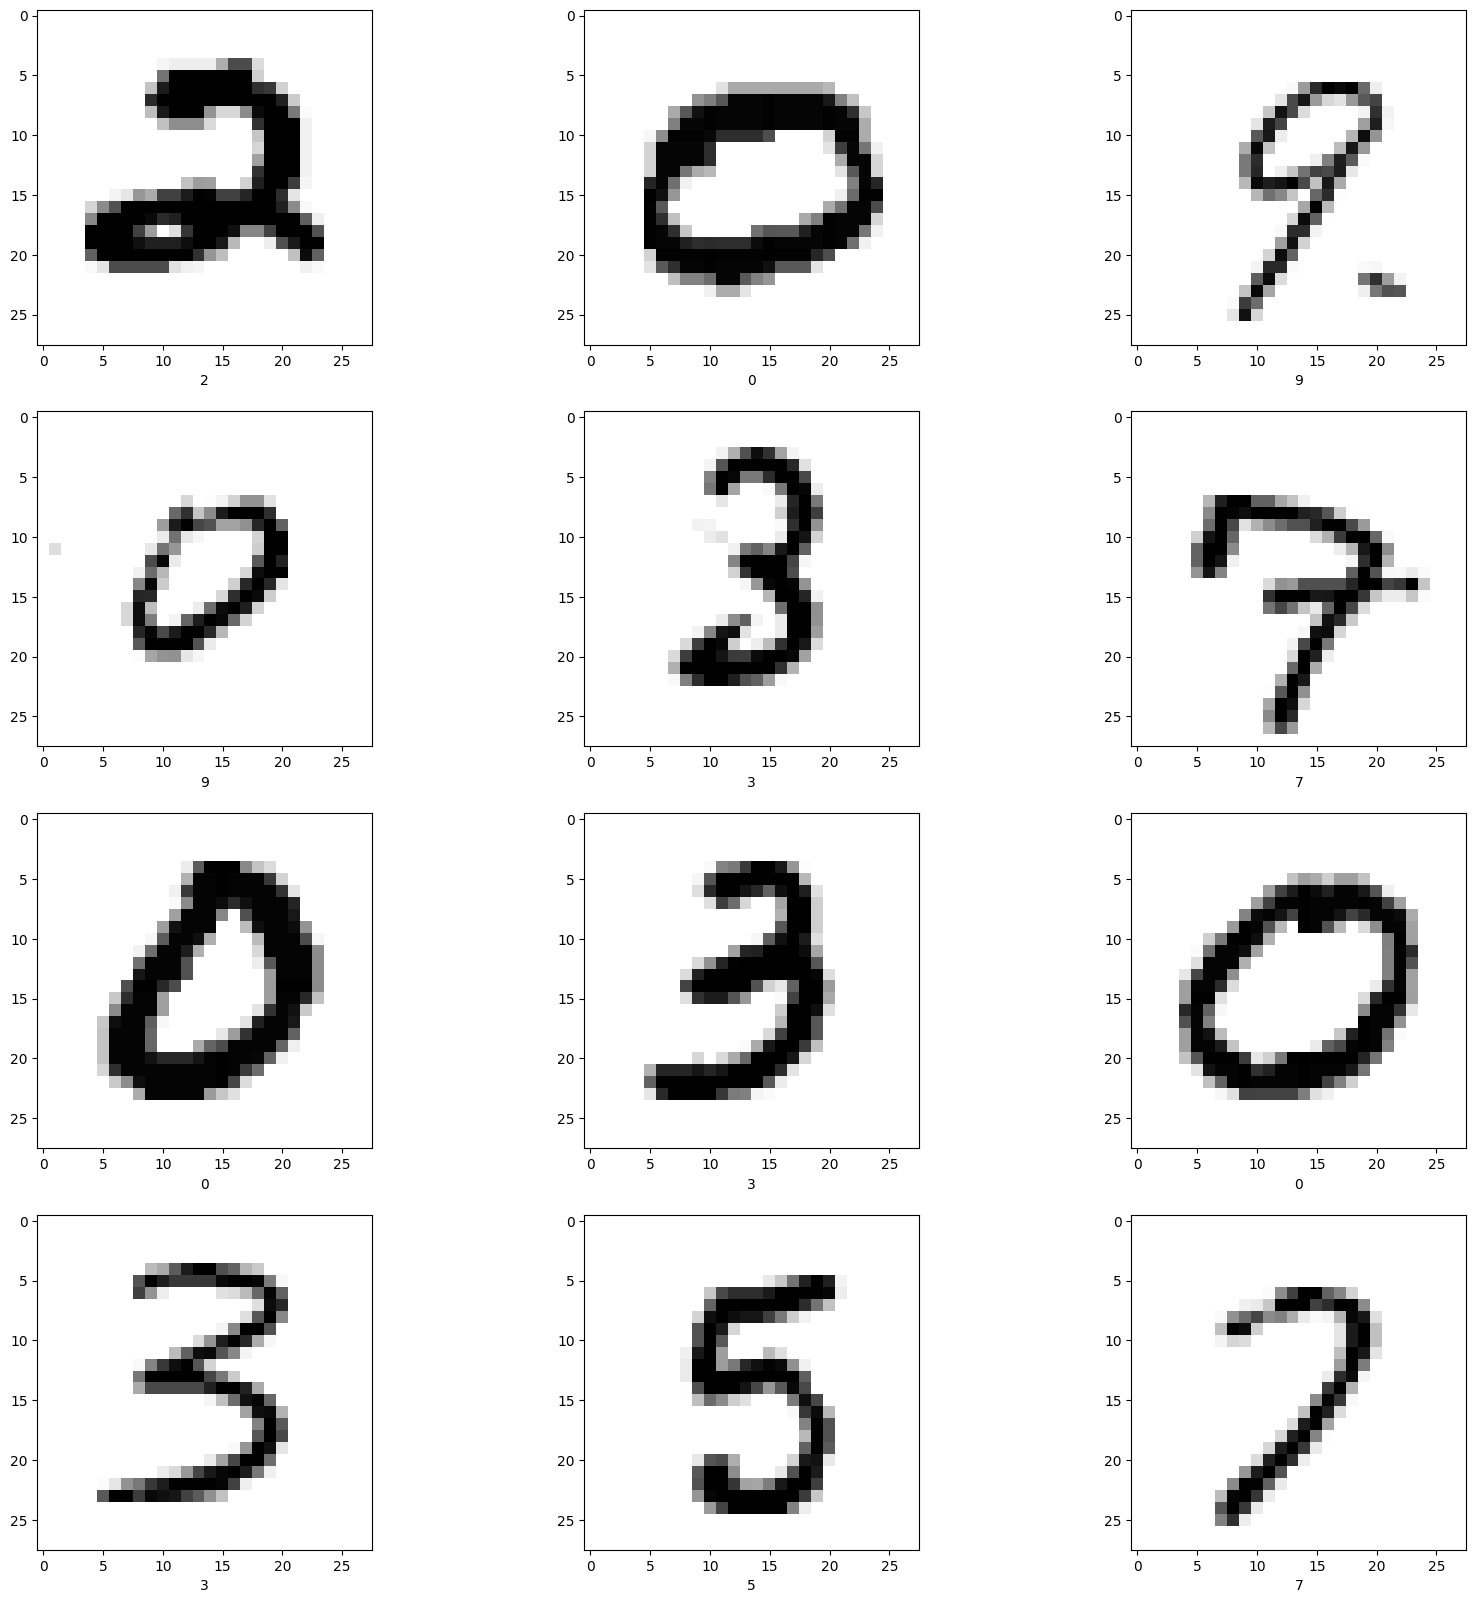

In [164]:
#printing a sample images
plt.figure(figsize=(20,20))
#showing random images from different classes
for i in range(50):
    plt.subplot(4,3, i+1)
    plt.imshow(np.array(test[i, :]).reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(y_pred[i])

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [125]:
y_pred = pd.Series(y_pred, name='Label')

In [126]:
sub = pd.concat([pd.Series(range(1, 28001), name="ImageId"), y_pred], axis=1)

In [127]:
sub

,ImageId,Label
0,1,8.0
1,2,1.0
2,3,9.0
3,4,9.0
4,5,8.0
...,...,...
27995,27996,NaN
27996,27997,NaN
27997,27998,NaN
27998,27999,NaN
